# Assignment4


## Contents
- Introduction
- Finite difference scheme with explicit time-stepping
- Finite difference scheme with implicit time-stepping
- Summary

## Introduction
In this assignment, we try to construct classical explicit and implicit finite difference scheme to numerically solve the problem related to 2-D heat conduction equation.The equation is as below:
$$
\begin{cases}
	u_t\left( x,y,t \right) =u_{xx}\left( x,y,t \right) +u_{yy}\left( x,y,t \right) , -1\leqslant x,y\leqslant 1, t>0\\
	u\left( x,1,t \right) =5, u\left( -1,y,t \right) =u\left( 1,y,t \right) =u\left( x,-1,t \right) =0, t>0\\
	u\left( x,y,0 \right) =0, -1\leqslant x\leqslant 1,-1\leqslant y<1\\
\end{cases}
$$
We are asked to find the time t\* when the temperature value in the middle of the plate turns to 1. The ideal solution of d\* with 12 digits is 0.424011387033.



In [91]:
import numpy as np
import numba
from numba import cuda
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import timeit

In [3]:
cuda.detect()

Found 1 CUDA devices
id 0    b'Tesla V100-SXM2-16GB'                              [SUPPORTED]
                      compute capability: 7.0
                           pci device id: 4
                              pci bus id: 0
Summary:
	1/1 devices are supported


True

In [286]:
# visualize temperature situation
def visualize(u):
    plt.figure(figsize=(8, 6))
    plt.imshow(u, origin='lower', extent=(-1, 1, -1, 1), cmap='Oranges')
    plt.colorbar()
    plt.show()

# Finite difference scheme with explicit time-stepping

Here we construct the explict difference format. Fot the left hand of the equation $u_t$, we utilize the forward difference format:
$$
u_t\left( x_i,y_j,t_n \right) \approx \frac{u_{i,j}^{n+1}-u_{i,j}^{n}}{\tau}
$$
While for right hand terms, we choose to use cernter difference to approximate $
u_{xx}\,\,and\,\,u_{yy}$:
$$
u_{xx}\left( x_i,y_j,t_n \right) \approx \frac{u_{i+1,j}^{n}-2u_{i,j}^{n}+u_{i-1,j}^{n}}{h^2}
\\
u_{yy}\left( x_i,y_j,t_n \right) \approx \frac{u_{i,j+1}^{n}-2u_{i,j}^{n}+u_{i,j-1}^{n}}{h^2}
$$
In the formulas above, $x_i=ih, y_j=jh,t_n=nτ, i=0,...,N-1, j=0,...,N-1,n\geqslant0,\left( N-1 \right)*h=2$
Therefore, the origin PDE could convert to the explicit time-stepping format:
$$
\begin{cases}
	u_{i,j}^{n+1}=\lambda \left( u_{i,j-1}^{n}+u_{i-1,j}^{n}+u_{i+1,j}^{n}+u_{i,j+1}^{n} \right) +\left( 1-4\lambda \right) u, i,j=0... N-1, n\geqslant 0\\
	u_{i,0}^{0}=5,u_{0,j}^{0}=u_{N-1,j}^{0}=u_{i,N-1}^{0}=0, i,j=0... N-1\\
	u_{i,j}^{n}=0, i=0...N-1, j=1...N-1, n\geqslant 0\\
\end{cases}
$$
This is classical explicit scheme for 2-D heat conduction equation.In this assignment, we implement it by numba.cuda.


In [13]:
@cuda.jit
def explict_iteration(current_depend,current_result,lmda):
  tx,ty=cuda.grid(2)
  if not (tx<current_result.shape[0]-2 and ty<current_result.shape[1]-2):
    return
  current_result[tx+1,ty+1]=lmda*(current_depend[tx+1,ty]+current_depend[tx,ty+1]+current_depend[tx+2,ty+1]+current_depend[tx+1,ty+2])\
              +(1-4*lmda)*current_depend[tx+1,ty+1]
  cuda.syncthreads()



In [280]:
def diffusion(N=201,time_interval=40000):
  h=2/(N-1) #Length of interval of positively correlated discretized grid. number of interval is N-1
  #-------------------------------------------------------------#
  tau=1/time_interval
  lmda=tau/(h**2)
  #----------------------------Initialize BPG & TPB----------------------------------#
  threadsperblock=(32,32)
  blockspergridx=(N+(threadsperblock[0]-1))//threadsperblock[0]
  blockspergridy=(N+(threadsperblock[1]-1))//threadsperblock[1]
  blockspergrid=(blockspergridx,blockspergridy)
  blockspergrid
  #--------------------------------Initialize global buffer------------------------------------------#
  current_depend=np.zeros((N,N))#Initialize the initial values of the grid points on the 2D board, the grid is meshed with a total of N*N grid points
  current_depend[0,:]=5 
  current_result=np.zeros_like(current_depend)
  current_result[0,:]=5
  #------------------------------to device--------------------------------------#
  #create global buffer,transfer data into global buffer
  current_depend_device=cuda.to_device(current_depend)
  current_result_device=cuda.to_device(current_result)
  final_result=np.zeros_like(current_result)
  for t in range(1,time_interval+1):
    explict_iteration[blockspergrid,threadsperblock](current_depend_device,current_result_device,lmda)
    current_depend_device,current_result_device=current_result_device,current_depend_device
    current_depend_device.copy_to_host(final_result)
    if 1.<final_result[int(((N+1)/2)-1),int(((N+1)/2)-1)]<2.:
      print(tau*t)
      print(t)
      break
  return str(tau*t),current_depend_device



We discretise 1 seconds into 10000,100000,1000000 intervals respectively, which means τ=0.00001,0.000001,0.0000001.According to the stability condition of classical explicit scheme deduced by founier method: $
\lambda =\frac{\tau}{h^2}=\frac{1/time\,\,intervals}{1/\left( N-1 \right) ^2}=\frac{\left( N-1 \right) ^2}{time\,\,intervals}\leqslant \frac{1}{4}
$, hence in order to guarantee stability, we need to set $\left( N-1 \right) ^2\leqslant 2500, 25000, 250000$ 

So according to condtion to ensure stability, when we set time_intervals=1000000, the range of N will be 3≤N≤501. We perform experiment on N=3,11,21,51,101,201 and find how many correct digits we can achieve. 

-Note: First line in output cell refers to the t\*, it is computed by $
\tau \times iteration\,\,times
$
,however its value tends to be easily affected by float structure.So we also print the second line, denoting the iteration times which can be used to caculate t\* precisely.

At the same time, we print heatmap of temperature of the plate under every cases, giving an intuitive picture for the iteration process.

In [281]:
r2,U2=diffusion(N=201,time_interval=1000000)

0.42401099999999997
424011


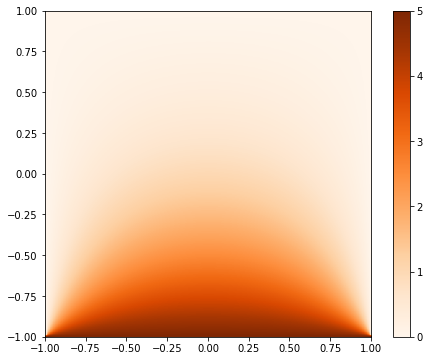

In [287]:
visualize(U2)

From the result,we find that $
t^*=\frac{1}{1000000}\times 424011=0.424011
$, which shares 6 equal digits with ideal t\*.

In [288]:
r3,U3=diffusion(N=101,time_interval=1000000)

0.424012
424012


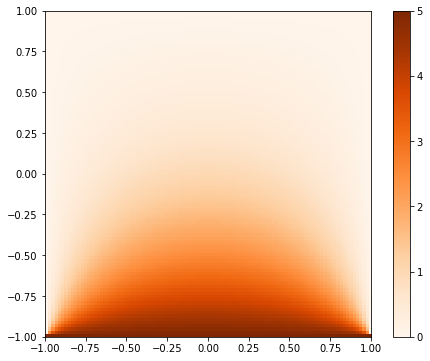

In [289]:
visualize(U3)

0.424016
424016


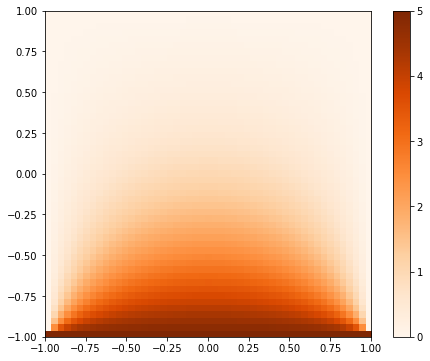

In [290]:
r4,U4=diffusion(N=51,time_interval=1000000)
visualize(U4)

In such cases, N decreases to 101 and then 51 and computed t\* shares 5 digits with ideal t\*.  

0.424042
424042


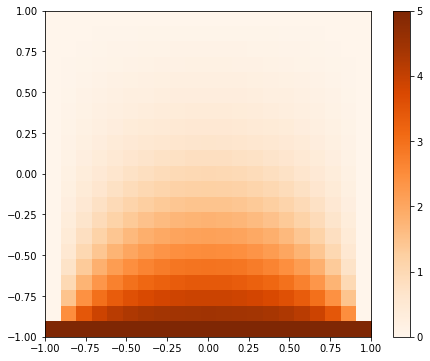

In [291]:
r5,U5=diffusion(N=21,time_interval=1000000)
visualize(U5)

0.42410899999999996
424109


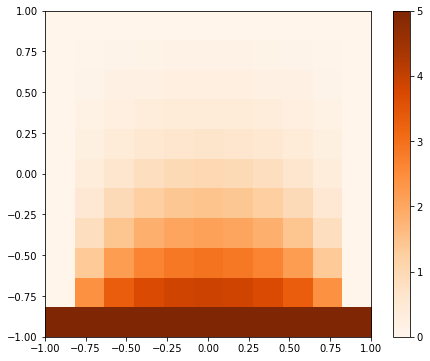

In [292]:
r6,U6=diffusion(N=11,time_interval=1000000)
visualize(U6)

0.40235899999999997
402359


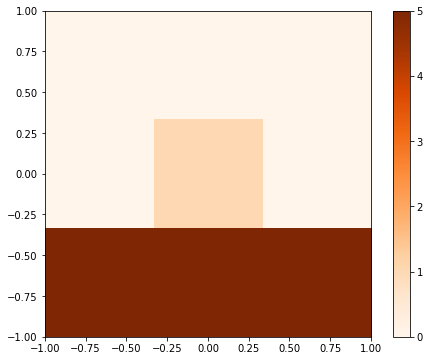

In [293]:
r7,U7=diffusion(N=3,time_interval=1000000)
visualize(U7)

With the degree of spatial dispersion decreases, our t\* has less and less equal digits with ideal t\*. We give an intuitive picture of the covergence of
computed time t\* against the actual time, with increasing the number of discretisation points.

In [276]:
N_candidates=[3,11,21,51,101,201]
t_star=[0.402359,0.424109,0.424042,0.424016,0.424012,0.424011]#truncate the unstable digit caused by float
t_ideal=0.424011387033
absolute_error=[]
for i in range(len(t_star)):
  absolute_error.append(abs(t_star[i]-t_ideal))
absolute_error

[0.021652387032999987,
 9.761296700000477e-05,
 3.061296699996552e-05,
 4.612966999995027e-06,
 6.12966999991027e-07,
 3.870329999822175e-07]

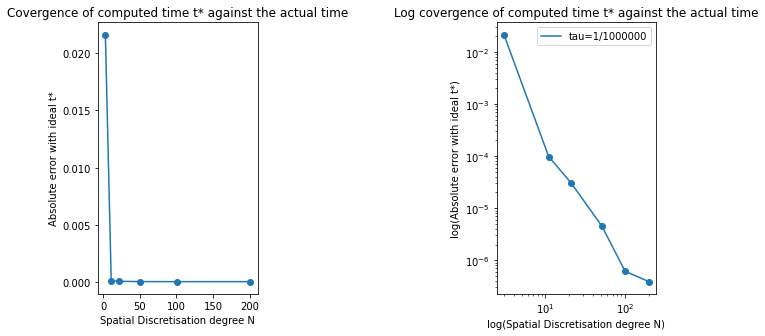

In [275]:
fig,ax=plt.subplots(1,2,figsize=(10,5))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=1.5, hspace=None)
ax[0].plot(N_candidates,absolute_error,label="tau=1/1000000")
ax[0].set_xlabel("Spatial Discretisation degree N")
ax[0].set_ylabel("Absolute error with ideal t*")
ax[0].scatter(N_candidates,absolute_error)
ax[0].set_title("Covergence of computed time t* against the actual time")
ax[1].loglog(N_candidates,absolute_error,label="tau=1/1000000")
ax[1].set_xlabel("log(Spatial Discretisation degree N)")
ax[1].set_ylabel("log(Absolute error with ideal t*)")
ax[1].scatter(N_candidates,absolute_error)
ax[1].set_title("Log covergence of computed time t* against the actual time")
plt.legend()

From the left picture, we find error declines dramatically with increasing of N before N=11, but after that t\*'s distance with actual time is very little, which means the absolute error of t\* and actual t converges after N=11.

From loglog picture, we can deduce from the trend that
$$
\log \left( error \right) =-2\log \left( N \right) +\log \left( A \right) 
\\
=-2\log \left( \frac{2}{h}+1 \right) +\log \left( A \right) 
\\
\Longrightarrow error\approx Ah^2 
$$
This result confirms that when time discretisation fix, the error has positive correlation relationship with $
h^2
$.

We also test based on time_interval=10000, i.e. τ=0.0001 and N=5,11,21,51


0.42400000000000004
4240


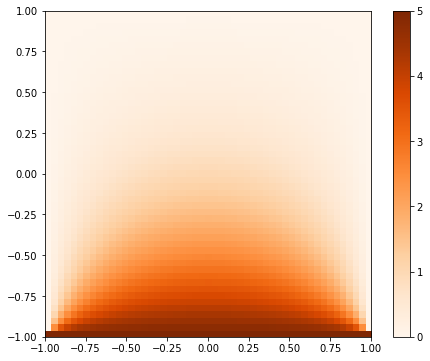

In [294]:
r_1,U_1=diffusion(N=51,time_interval=10000)
visualize(U_1)

0.42400000000000004
4240


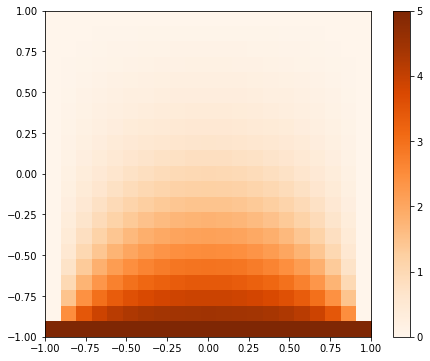

In [295]:
r_2,U_2=diffusion(N=21,time_interval=10000)
visualize(U_2)

0.42410000000000003
4241


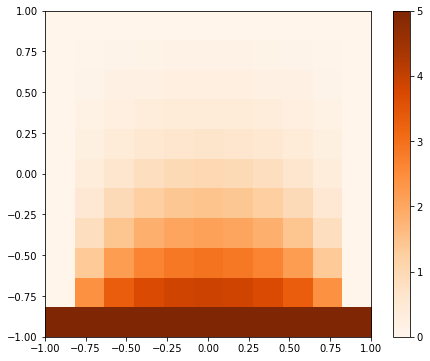

In [296]:
r_3,U_3=diffusion(N=11,time_interval=10000)
visualize(U_3)

0.42310000000000003
4231


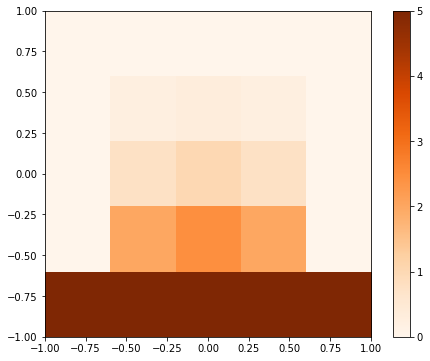

In [297]:
r_4,U_4=diffusion(N=5,time_interval=10000)
visualize(U_4)

Let's see what will happen when we do not obey the stability condition,we choose N=61,101,151,301

0.42400000000000004
4240


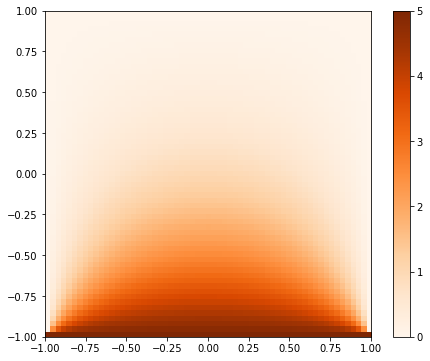

In [298]:
r_6,U_6=diffusion(N=61,time_interval=10000)
visualize(U_6)

0.42400000000000004
4240


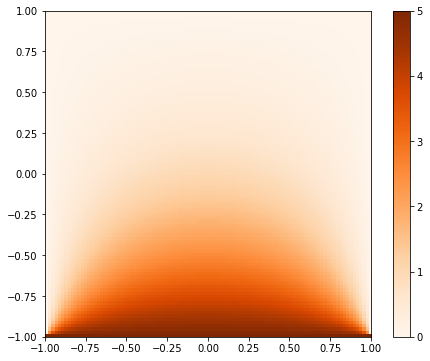

In [299]:
r_7,U_7=diffusion(N=101,time_interval=10000)
visualize(U_7)

We find that when we choose N=61 and 101, computed t* still shares 3 same digits with actual time. However, this evidence cannot guarantee that the error of $u_{i,j}^{0}$ are not passed to $u_{i,j}^{4240}$.

0.0129
129


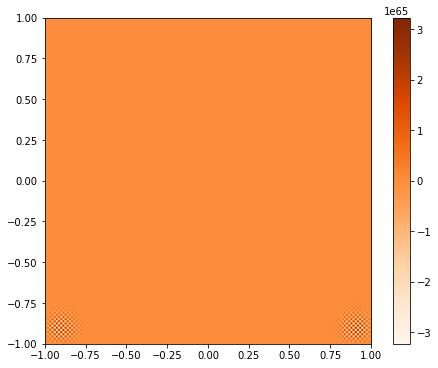

In [300]:
r_8,U_8=diffusion(N=151,time_interval=10000)
visualize(U_8)

From here，we find that when N=151, the error of $u_{i,j}^{0}$ has been expaned in $u_{i,j}^{129}$. t\* of this time has no equal digits with actual time.

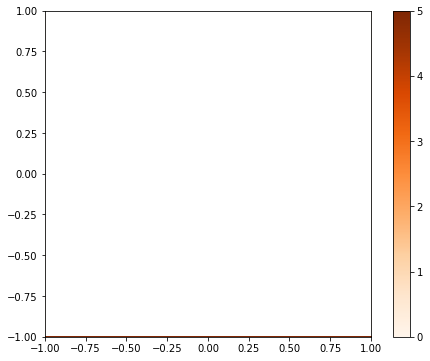

In [301]:
r_9,U_9=diffusion(N=301,time_interval=10000)
visualize(U_9)

In [243]:
print(r_9)

1.0


When N=301, the u value of middle point is even not equal to 1 ,after finishing 10000 times iteration.It is evident that the difference scheme is quite unstable under this circumstance.

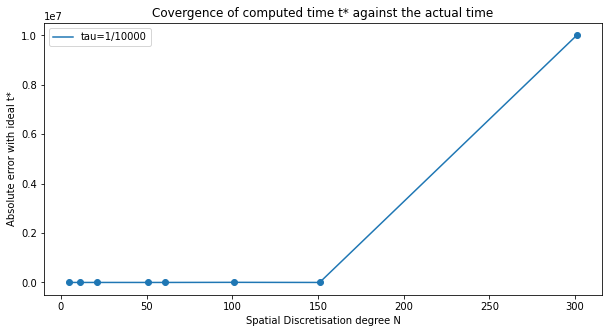

In [279]:
def plot():
  N_candidates=[5,11,21,51,61,101,151,301]
  t_star=[0.4231,0.4241,0.4240,0.4240,0.4240,4240,0.129,10000000]#truncate the unstable digit caused by float,and we use 10000000 to denote inf
  t_ideal=0.424011387033
  absolute_error=[]
  for i in range(len(t_star)):
    absolute_error.append(abs(t_star[i]-t_ideal))
  fig,ax=plt.subplots(figsize=(10,5))
  ax.plot(N_candidates,absolute_error,label="tau=1/10000")
  ax.set_xlabel("Spatial Discretisation degree N")
  ax.set_ylabel("Absolute error with ideal t*")
  ax.scatter(N_candidates,absolute_error)
  ax.set_title("Covergence of computed time t* against the actual time")
  plt.legend()
plot()

We can easily observe the unstablility of the explicit scheme from above picture. When λ satisfies the stability condition, error between t* and actual converges, otherwise, error diverge to a large degree.

# Finite difference scheme with implicit time-stepping

Our explicit time-stepping scheme is not global stable, so it is easy to make the error expand to an unimaginable degree and make our difference scheme meaningless. So here, we also gives a implicit difference scheme, which is unconditional stable.

Fot the left hand of the equation $u_t$, we utilize the backward difference format:
$$
u_t\left( x_i,y_j,t_n \right) \approx \frac{u_{i,j}^{n}-u_{i,j}^{n-1}}{\tau}
$$
While for right hand terms, we still choose to use cernter difference to approximate $
u_{xx}\,\,and\,\,u_{yy}$:
$$
u_{xx}\left( x_i,y_j,t_n \right) \approx \frac{u_{i+1,j}^{n}-2u_{i,j}^{n}+u_{i-1,j}^{n}}{h^2}
\\
u_{yy}\left( x_i,y_j,t_n \right) \approx \frac{u_{i,j+1}^{n}-2u_{i,j}^{n}+u_{i,j-1}^{n}}{h^2}
$$
In the formulas above, $x_i=ih, y_j=jh,t_n=nτ, i=0,...,N-1, j=0,...,N-1,n\geqslant1,\left( N-1 \right)*h=2$
Therefore, the origin PDE could convert to the implicit time-stepping format,which can be solved by solving linear equations system:
$$
\begin{cases}
	-\lambda u_{i-1,j}^{n}-\lambda u_{i,j-1}^{n}+\left( 1+4\lambda \right) u_{i,j}^{n}-\lambda u_{i,j+1}^{n}-\lambda u_{i+1,j}^{n}=u_{i,j}^{n-1}, i,j=0... N-1, n\geqslant 1\\
	u_{i,0}^{0}=5,u_{0,j}^{0}=u_{N-1,j}^{0}=u_{i,N-1}^{0}=0, i,j=0... N-1\\
	u_{i,j}^{n}=0, i=0...N-1, j=1...N-1, n\geqslant 1\\
\end{cases}
$$



We implement the implicit scheme as codes shown:

In [108]:
#We modify the programme of discretise_possion into discretise_diffusion to generate the coefficients matrix of our linear equations system.
def discretise_diffusion(N,lmda):
    """Generate the matrix and rhs associated with the discrete Poisson operator."""
    
    nelements=5*N**2-16*N+16
    
    row_ind=np.empty(nelements,dtype=np.float64)
    col_ind=np.empty(nelements,dtype=np.float64)
    data=np.empty(nelements,dtype=np.float64)
    
    U_initial=np.empty(N*N,dtype=np.float64)
    
    count=0
    for j in range(N):
      for i in range(N):
        
        if i==N-1 or i==0 or j==N-1 or j==0:
          row_ind[count]=col_ind[count]=j*N+i
          data[count]=1
          if j==0:
            U_initial[j*N+i]=5
          else:
            U_initial[j*N+i]=0
          count+=1
                
        else:
          row_ind[count:count+5]=j*N+i
          col_ind[count]=j*N+i
          col_ind[count+1]=j*N+i+1
          col_ind[count+2]=j*N+i-1
          col_ind[count+3]=(j+1)*N+i
          col_ind[count+4]=(j-1)*N+i
                          
          data[count]=1+4*lmda
          data[count+1:count+5]=-lmda
          U_initial[j*N+i]=0         
          count+=5                                              
    return coo_matrix((data, (row_ind, col_ind)), shape=(N**2, N**2)).tocsr(), U_initial

In [304]:
def implicit_diffusion(N=201,time_interval=40001):
  h=2/(N-1) 
  #-------------------------------------------------------------#
  tau=1/time_interval
  lmda=tau/(h**2)
  #-------------------------------------#
  A,U_0=discretise_diffusion(N,lmda)
  current_depend=spsolve(A,U_0)
  for t in range(1,time_interval+1):
    current_result=spsolve(A,current_depend)
    current_depend,current_result=current_result,current_depend
    #print(current_depend.shape)
    if 1.< current_depend[int((current_depend.shape[0]+1)/2)-1] <2.:
      print(tau*(t+1))
      print(t+1)
      break
  return str(tau*(t+1)),current_depend.reshape(N,N)

0.40237
40237


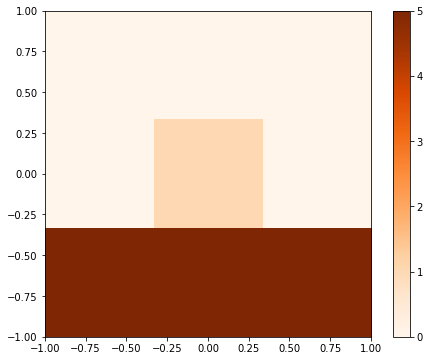

In [306]:
r_1,IU1=implicit_diffusion(N=3,time_interval=100000)
visualize(IU1)

0.42413
42413


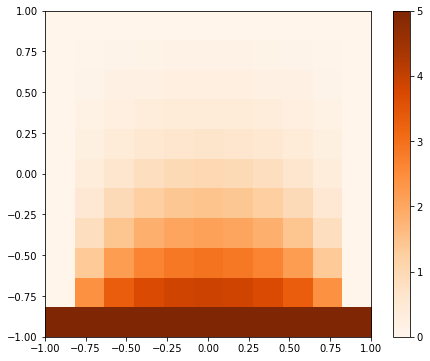

In [307]:
r_2,IU2=implicit_diffusion(N=11,time_interval=100000)
visualize(IU2)

0.42405000000000004
42405


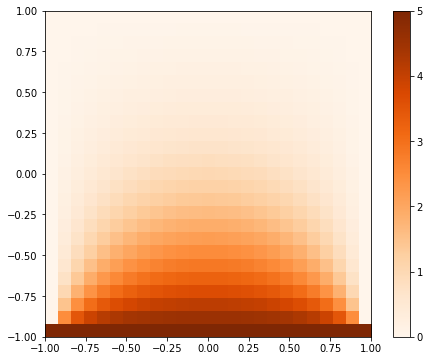

In [308]:
r_3,IU3=implicit_diffusion(N=25,time_interval=100000)
visualize(IU3)

0.42403
42403


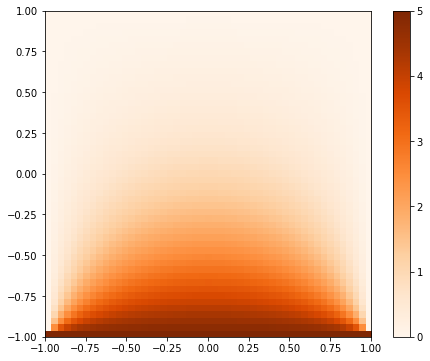

In [309]:
r_4,IU4=implicit_diffusion(N=51,time_interval=100000)
visualize(IU4)

We find that t* in this case shares at most 4 digits with actual time.

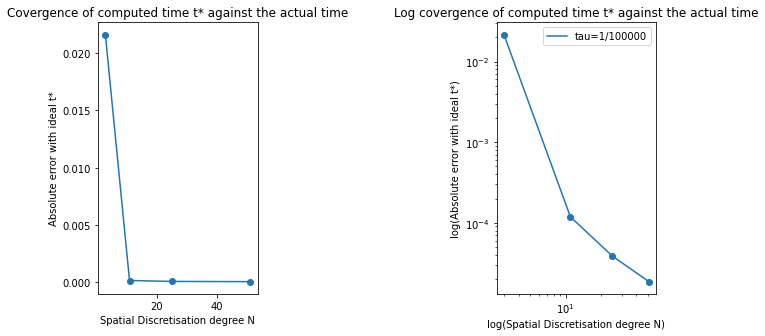

In [311]:
def plot_implicit():
  N_candidates=[3,11,25,51]
  t_star=[0.40237,0.42413,0.42405,0.42403]#truncate the unstable digit caused by float,and we use 10000000 to denote inf
  t_ideal=0.424011387033
  absolute_error=[]
  for i in range(len(t_star)):
    absolute_error.append(abs(t_star[i]-t_ideal))
  fig,ax=plt.subplots(1,2,figsize=(10,5))
  plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=1.5, hspace=None)
  ax[0].plot(N_candidates,absolute_error,label="tau=1/100000")
  ax[0].set_xlabel("Spatial Discretisation degree N")
  ax[0].set_ylabel("Absolute error with ideal t*")
  ax[0].scatter(N_candidates,absolute_error)
  ax[0].set_title("Covergence of computed time t* against the actual time")
  ax[1].loglog(N_candidates,absolute_error,label="tau=1/100000")
  ax[1].set_xlabel("log(Spatial Discretisation degree N)")
  ax[1].set_ylabel("log(Absolute error with ideal t*)")
  ax[1].scatter(N_candidates,absolute_error)
  ax[1].set_title("Log covergence of computed time t* against the actual time")
  plt.legend()
plot_implicit()

The error curve satisfies our expectation, error decreases with dicretisation degree increasing and the trend of log(error) aginst log(Absolute error with ideal t*) is same with explicit scheme.

# Summary


From experiments, we can conclude several things:
- Classical time-stepping explicit scheme is conditional stable, the condition is $\lambda =\frac{\tau}{h^2}\leqslant \frac{1}{4}$, however this scheme is very easy and convenient because we don't need to solve linear equation systems under this case and very easy to implement on CUDA. 
- Find a solution to classical time-stepping implicit scheme needs us to solve a linear system of equations, but generally numerically stable, larger time steps can be used。
- Classical time-stepping explicit and implicit scheme are both with second-order spatial accuracy, which means the error convergence has  the error has positive correlation relationship with $
h^2
$. 
 